In [2]:
from empath import Empath
import pandas as pd
import matplotlib.pyplot as plt
import datetime

lexicon = Empath()

# Loading the processed DataFrame into notebook
final_df = pd.read_pickle("/Users/Justin/Desktop/ADA_project/final_dataset/quotes_bert_tok.pkl", compression='infer')

# Remove hour from date timestamp: 
final_df['date'] = final_df.date.dt.date

# New column with only year and month:
final_df['month_year'] = pd.to_datetime(final_df.date, format='%Y-%m-%d') # format the datetime
final_df['month_year'] = final_df['month_year'].dt.strftime('%Y-%m') # extract only year and month

# Ensure df is in increasing date order
final_df = final_df.sort_values('date', ascending=True)
final_df.head()

,speaker,qids,date,quotation,keyword,scores,compound,sent_type,tokens,N_of_tokens,Bert_sentiment_type,Tok_Bert,month_year
4245,Bob Knight,"[Q16538199, Q4933049, Q888594]",2015-01-01,"The likelihood of a school shooting is remote,...",school shooting,"{'neg': 0.06, 'neu': 0.94, 'pos': 0.0, 'compou...",-0.0857,NEG,"[The, likelihood, of, a, school, shooting, is,...",26,neutral,30,2015-01
4556,Joe Rogan,[Q2718421],2015-01-01,But I'm also a gun owner. I'm in the NRA. I'm ...,gun owner,"{'neg': 0.141, 'neu': 0.859, 'pos': 0.0, 'comp...",-0.7227,NEG,"[But, I, 'm, also, a, gun, owner, ., I, 'm, in...",50,neutral,60,2015-01
5067,Gayle McLaughlin,[Q5528807],2015-01-01,Young men who are typically traditionally hist...,gun violence,"{'neg': 0.341, 'neu': 0.546, 'pos': 0.114, 'co...",-0.8860,NEG,"[Young, men, who, are, typically, traditionall...",33,positive,35,2015-01
4878,Jose R. Rodriguez,[Q6293772],2015-01-01,"Given Congress's inability to enact sensible, ...",gun violence,"{'neg': 0.262, 'neu': 0.513, 'pos': 0.225, 'co...",-0.3182,NEG,"[Given, Congress, 's, inability, to, enact, se...",28,positive,34,2015-01
1716,Larry Hogan,"[Q1119051, Q16731303]",2015-01-02,Gun owners not welcome here.,gun owner,"{'neg': 0.619, 'neu': 0.381, 'pos': 0.0, 'comp...",-0.5967,NEG,"[Gun, owners, not, welcome, here, .]",6,negative,8,2015-01


In [3]:
# Import mass shooting dataset:

DATA_FOLDER = '/Users/Justin/Desktop/ADA_project/shooting_dataset/'

MASS_SHOOTINGS_15 = DATA_FOLDER+"massshootings15.csv"
MASS_SHOOTINGS_16 = DATA_FOLDER+"massshootings16.csv"
MASS_SHOOTINGS_17 = DATA_FOLDER+"massshootings17.csv"
MASS_SHOOTINGS_18 = DATA_FOLDER+"massshootings18.csv"
MASS_SHOOTINGS_19 = DATA_FOLDER+"massshootings19.csv"
ACCIDENTS = DATA_FOLDER+"accidents.csv"

mass_shootings_15 = pd.read_csv(MASS_SHOOTINGS_15)
mass_shootings_16 = pd.read_csv(MASS_SHOOTINGS_16)
mass_shootings_17 = pd.read_csv(MASS_SHOOTINGS_17)
mass_shootings_18 = pd.read_csv(MASS_SHOOTINGS_18)
mass_shootings_19 = pd.read_csv(MASS_SHOOTINGS_19)
accidents = pd.read_csv(ACCIDENTS)

mass_shootings=pd.concat([mass_shootings_15, mass_shootings_16, mass_shootings_17, mass_shootings_18,
                          mass_shootings_19], ignore_index=True)

mass_shootings = mass_shootings.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
mass_shootings['Category']='Mass Shooting'
mass_shootings['Incident Date'] = pd.to_datetime(mass_shootings['Incident Date'])
accidents = accidents.drop(columns=['State', 'City Or County', 'Address', 'Operations'])
accidents = accidents[~accidents['Incident Date'].str.contains("2021")]
accidents = accidents[~accidents['Incident Date'].str.contains("2020")]
accidents['Category']='Accident'
accidents['Incident Date'] = pd.to_datetime(accidents['Incident Date'])

mass_shootings=mass_shootings.sort_values('Incident Date', ascending=True)
mass_shootings.head()

,Incident ID,Incident Date,# Killed,# Injured,Category
334,272016,2015-01-01,0,5,Mass Shooting
333,273965,2015-01-02,1,4,Mass Shooting
332,273397,2015-01-04,3,1,Mass Shooting
331,273535,2015-01-04,2,4,Mass Shooting
330,274867,2015-01-06,1,3,Mass Shooting


In [4]:
# Run emotion analysis over the whole dataset: 

anger = []
aggression = []
joy = []
pride = []
sadness = []
suffering = []
fear = []
disappointment = []
optimism = []

# Categories worth evaluating
cats = ["anger", "aggression", "joy", "pride", "nervousness", "suffering", "fear", "neglect", "deception",
        "disgust", "optimism", "sadness", "disappointment"]

# Run algorithm
for quote in final_df.quotation:
    empath_features = lexicon.analyze(quote, categories = cats, normalize = True)
    anger.append(empath_features["anger"])
    aggression.append(empath_features["aggression"])
    joy.append(empath_features["joy"])
    optimism.append(empath_features["optimism"])
    sadness.append(empath_features["sadness"])
    suffering.append(empath_features["suffering"])
    fear.append(empath_features["fear"])
    disappointment.append(empath_features["disappointment"])


# Store result in dataframe
data = {'anger': anger, 'aggression': aggression, 'joy': joy, 'optimism': optimism, 'sadness': sadness,
        'suffering': suffering, 'fear': fear, 'disappointment': disappointment}
emotion_df = pd.DataFrame(data)
emotion_df['date'] = final_df['date'].values
emotion_df['month_year'] = final_df['month_year'].values


In [5]:
# Average score of each category per day (or month): 

anger = []
aggression = []
joy = []
optimism = []
sadness = []
suffering = []
fear = []
disappointment = []
date = []

# Group quotes by month and compute average score
grouped_df = emotion_df.groupby(['month_year'])
for group in grouped_df:
    date.append(group[0])
    anger.append(group[1].anger.mean())
    aggression.append(group[1].aggression.mean())
    joy.append(group[1].joy.mean())
    optimism.append(group[1].optimism.mean())
    sadness.append(group[1].sadness.mean())
    suffering.append(group[1].suffering.mean())
    fear.append(group[1].fear.mean())
    disappointment.append(group[1].disappointment.mean())

# Store result in new df
data = {'date': date, 'anger': anger, 'aggression': aggression, 'joy': joy, 'optimism': optimism, 
         'sadness': sadness, 'suffering': suffering, 'fear': fear, 'disappointment': disappointment}
daily_emotion_df = pd.DataFrame(data)

daily_emotion_df=daily_emotion_df.sort_values('date', ascending=True)
daily_emotion_df.head()

,date,anger,aggression,joy,optimism,sadness,suffering,fear,disappointment
0,2015-01,0.000623,0.009055,0.000569,0.001845,0.002380,0.003045,0.001902,0.000183
1,2015-02,0.001445,0.011210,0.000000,0.001713,0.001827,0.003545,0.001921,0.000931
2,2015-03,0.000395,0.012400,0.000111,0.002610,0.001242,0.001713,0.000633,0.000226
3,2015-04,0.000177,0.011948,0.000000,0.002521,0.000647,0.002576,0.000964,0.000203
4,2015-05,0.000333,0.012669,0.000481,0.003064,0.001300,0.001570,0.000775,0.000394


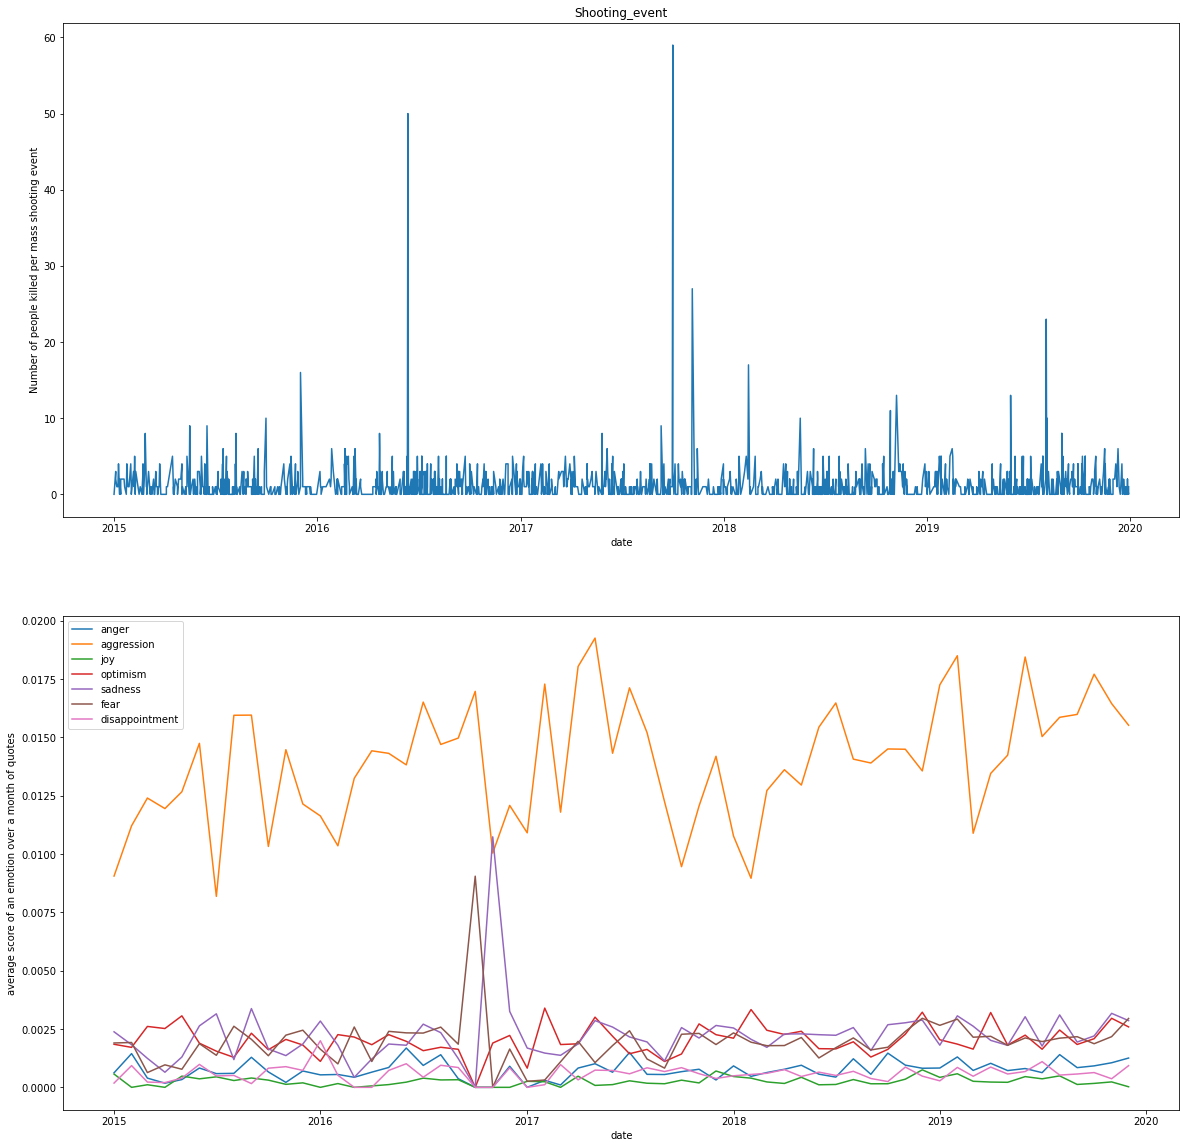

In [6]:
# Set the dates back to date_time in order to graph easily
daily_emotion_df.date=pd.to_datetime(daily_emotion_df.date)

# Graph result
fig, ax = plt.subplots(2, 1);
fig.set_size_inches(20, 20)

ax[0].plot(mass_shootings['Incident Date'], mass_shootings['# Killed']);
ax[0].set_title('Shooting_event');
ax[0].set_xlabel("date");
ax[0].set_ylabel('Number of people killed per mass shooting event');

ax[1].plot(daily_emotion_df.date, daily_emotion_df.anger,label = "anger");
ax[1].plot(daily_emotion_df.date, daily_emotion_df.aggression,label = "aggression");
ax[1].plot(daily_emotion_df.date, daily_emotion_df.joy,label = "joy");
ax[1].plot(daily_emotion_df.date, daily_emotion_df.optimism,label = "optimism");
ax[1].plot(daily_emotion_df.date, daily_emotion_df.sadness,label = "sadness");
#ax[1].plot(daily_emotion_df.date, daily_emotion_df.suffering,label = "suffering");
ax[1].plot(daily_emotion_df.date, daily_emotion_df.fear,label = "fear");
ax[1].plot(daily_emotion_df.date, daily_emotion_df.disappointment,label = "disappointment");

ax[1].set_xlabel("date");
ax[1].set_ylabel("average score of an emotion over a month of quotes");
ax[1].legend();


In [7]:
# Mainly aggression, followed by suffering. 
# Then we have on par: fear and sadness, and on one occasion late 2016 in high quantity.
# Also have quite a bit of optimism. 
# Finally we have very little anger, disappointment and joy. 

### Run the emotion analysis in short time frame surrounding a few significant gun shooting events 

In [8]:
# Importing table with significant individual shootings worth investigating:
DATA_FOLDER = '/Users/Justin/Desktop/ADA_project/shooting_dataset/'
SELECTED_SHOOTINGS = DATA_FOLDER+"selected_shooting.csv"
selected_shootings = pd.read_csv(SELECTED_SHOOTINGS)

selected_df = pd.DataFrame(selected_shootings)
selected_df = selected_df.drop(selected_df.columns[[0]], axis=1) # Drop first column which has no ID
selected_df['date'] = pd.to_datetime(selected_df.date, format='%Y-%m-%d') # format the datetime
selected_df['date'] = selected_df.date.dt.date # remove hour from timestamp

selected_df = selected_df.sort_values('date', ascending=True)
selected_df.head()
# This table contains 15 events

,Incident ID,# Killed,# Injured,date
0,359830,9,0,2015-06-17
1,390526,8,0,2015-08-08
2,423223,10,9,2015-10-01
3,456893,16,19,2015-12-02
4,545525,8,0,2016-04-22


In [9]:
from datetime import datetime, timedelta

delta = 5 # Specify the time delta we wish to analyse

# Categories worth evaluating
cats = ["anger", "aggression", "joy", "pride", "nervousness", "suffering", "fear", "neglect", "deception",
        "disgust", "optimism", "sadness", "disappointment"]

anger = []
aggression = []
joy = []
pride = []
sadness = []
suffering = []
fear = []
disappointment = []
optimism = []

event_ID = []
dates = []

for date in selected_df.date:
    # define acceptable time interval:
    start = (date - timedelta(days=delta))
    end = (date + timedelta(days=delta))
    
    # extract quotes within desired timeframe:
    current_quotes = final_df[final_df.date >= start]
    current_quotes = current_quotes[current_quotes.date <= end]
    
    # Retrieve incident ID being analysed:
    current_ID = int(selected_df[selected_df.date == date]['Incident ID'])
    
    # Retrieve dates of all quotes analyzed for event in question:
    dates = dates + list(current_quotes['date'])

    # Run algorithm
    for quote in current_quotes.quotation:
        empath_features = lexicon.analyze(quote, categories = cats, normalize = True)
        anger.append(empath_features["anger"])
        aggression.append(empath_features["aggression"])
        joy.append(empath_features["joy"])
        optimism.append(empath_features["optimism"])
        sadness.append(empath_features["sadness"])
        suffering.append(empath_features["suffering"])
        fear.append(empath_features["fear"])
        disappointment.append(empath_features["disappointment"])
        event_ID.append(current_ID)
    
    
    # Store result in dataframe
    data = {'event_ID': event_ID, 'date': dates, 'anger': anger, 'aggression': aggression, 'joy': joy, 
            'optimism': optimism, 'sadness': sadness, 'suffering': suffering, 'fear': fear, 
            'disappointment': disappointment}
    emotion_df = pd.DataFrame(data)    

emotion_df.head()

,event_ID,date,anger,aggression,joy,optimism,sadness,suffering,fear,disappointment
0,359830,2015-06-12,0.0,0.00,0.0,0.025641,0.025641,0.000000,0.0,0.0
1,359830,2015-06-12,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,359830,2015-06-12,0.0,0.04,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,359830,2015-06-12,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,359830,2015-06-12,0.0,0.00,0.0,0.000000,0.038462,0.038462,0.0,0.0


In [10]:
# Average score of each category per day (or month): 

anger = []
aggression = []
joy = []
optimism = []
sadness = []
suffering = []
fear = []
disappointment = []
date = []
event_ID = []

# Group quotes by day and compute average score

grouped_df_init = emotion_df.groupby(['event_ID'])
for group_init in grouped_df_init:
    
    # Note: we have to group twice, first by event_ID and then by date, as some events are close together and 
    # overlap on quotes but must still be treated seperately
    grouped_df = group_init[1].groupby(['date'])
    for group in grouped_df:
        date.append(group[0])
        event_ID.append(group_init[0])
        anger.append(group[1].anger.mean())
        aggression.append(group[1].aggression.mean())
        joy.append(group[1].joy.mean())
        optimism.append(group[1].optimism.mean())
        sadness.append(group[1].sadness.mean())
        suffering.append(group[1].suffering.mean())
        fear.append(group[1].fear.mean())
        disappointment.append(group[1].disappointment.mean())

# Store result in new df
data = {'date': date, 'event_ID': event_ID, 'anger': anger, 'aggression': aggression, 'joy': joy, 
        'optimism': optimism, 'sadness': sadness, 'suffering': suffering, 'fear': fear, 
        'disappointment': disappointment}
daily_emotion_df = pd.DataFrame(data)


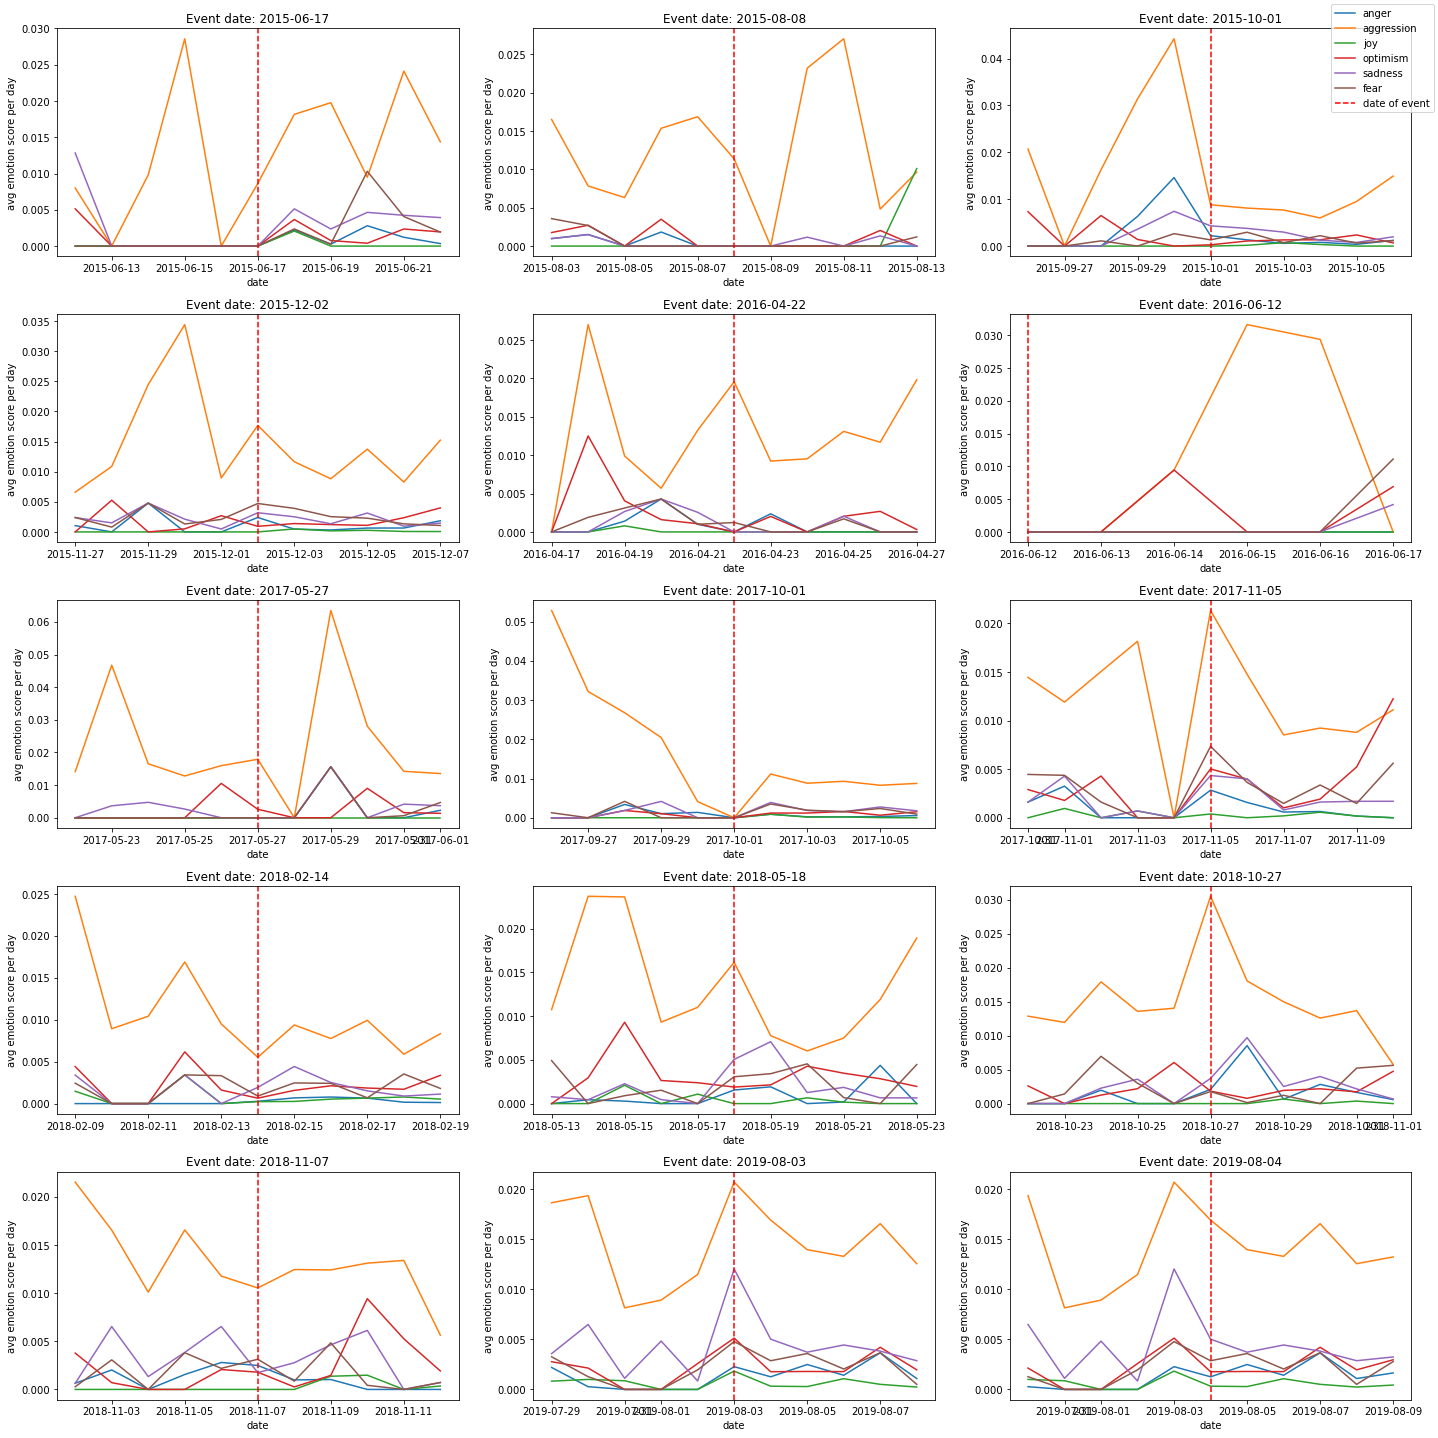

In [11]:
# Set the dates back to date_time in order to graph easily
#daily_emotion_df.date=pd.to_datetime(daily_emotion_df.date)

# Graph result
fig, ax = plt.subplots(5, 3);
fig.set_size_inches(20, 20)

idx = 0

# Group scores by event_ID to plot each graph
grouped_df = daily_emotion_df.groupby(['event_ID'])
for group in grouped_df:
    row_num = (idx // 3)
    col_num = (idx - 3*row_num)
    idx += 1
    ax[row_num,col_num].plot(group[1].date, group[1].anger,label = "anger");
    ax[row_num,col_num].plot(group[1].date, group[1].aggression,label = "aggression");
    ax[row_num,col_num].plot(group[1].date, group[1].joy,label = "joy");
    ax[row_num,col_num].plot(group[1].date, group[1].optimism,label = "optimism");
    ax[row_num,col_num].plot(group[1].date, group[1].sadness,label = "sadness");
    #ax[row_num,col_num].plot(group[1].date, group[1].suffering,label = "suffering");
    ax[row_num,col_num].plot(group[1].date, group[1].fear,label = "fear");
    #ax[row_num,col_num].plot(group[1].date, group[1].disappointment,label = "disappointment");
    
    current_event_date = selected_df['date'].iloc[idx - 1]
    
    ax[row_num,col_num].axvline(x=current_event_date, label='date of event'.format(current_event_date),
                                c='r', linestyle='--')

    ax[row_num,col_num].set_xlabel("date");
    ax[row_num,col_num].set_ylabel("avg emotion score per day");
    ax[row_num,col_num].set_title('Event date: '+str(current_event_date));


handles, labels = ax[row_num,col_num].get_legend_handles_labels();
fig.legend(handles, labels, loc='upper right');
fig.tight_layout()

Note that the event on the 12th June 2016 is not a coding error, there are genuinely no quotes relating to gun violence in the 5 days prior to this event. 
Question: Does the quotebank dataset have a blank in those fews days?

### Run the emotion analysis over entire timeframe but looking at a few key speakers

In [12]:
# Group by speakers to identify how many quotes they contribute
grouped_df = final_df.groupby(['speaker'])
speaker = []
num_quotes = []
for group in grouped_df:
    speaker.append(group[0])
    num_quotes.append(group[1].shape[0])
# Store result in df
data = {'speaker': speaker, 'num_quotes': num_quotes}
speaker_df = pd.DataFrame(data)

speaker_df = speaker_df.sort_values('num_quotes', ascending=False)
speaker_df.head(15)

,speaker,num_quotes
4331,Hillary Clinton,512
9133,President Barack Obama,409
1921,Chris Murphy,385
9141,President Obama,343
8443,Nancy Pelosi,342
9139,President Donald Trump,313
176,Alan Gottlieb,295
2778,David Hogg,288
947,Bernie Sanders,251
435,Andrew Cuomo,247


In [15]:
# From this result we can identify the top 10 speakers but we will have to account for the fact that they
# often appear under different names: 

top_10_names = ['Hillary Clinton', 'Barack Obama', 'Chris Murphy', 'Nancy Pelosi', 'Donald Trump', 'Alan Gottlieb',
               'David Hogg', 'Bernie Sanders', 'Andrew Cuomo', 'Richard Blumenthal']

# We will attempt to identify quotes from these ten people, but will adds an extra keyword for presidents:
key_words = top_10_names + ['President Obama', 'President Trump']

# Keep only quotes from top 10 speakers:
def keyword(row):
    strings = row['speaker']
    key_word = [key for key in key_words if key.upper() in strings.upper()]
    return ', '.join(key_word)

# Filter for to keep only speakers who'se name figures on the key_words list:
final_df['keyword'] = final_df.apply(keyword, axis=1)
top_10_df = final_df[final_df.keyword != '']

# Now we replace speaker names under various forms by one final name to uniformalize the list:
for i in range(10):
    cond = top_10_df.keyword==key_words[i]
    top_10_df.loc[cond, 'speaker'] = top_10_names[i]

# Finally we do the same for our two presidents: 
# Obama:
cond = top_10_df.keyword==key_words[10]
top_10_df.loc[cond, 'speaker'] = top_10_names[1]
# Trump:
cond = top_10_df.keyword==key_words[11]
top_10_df.loc[cond, 'speaker'] = top_10_names[4]


In [16]:
# Run emotion analysis over the whole dataset: 

anger = []
aggression = []
joy = []
pride = []
sadness = []
suffering = []
fear = []
disappointment = []
optimism = []

# Categories worth evaluating
cats = ["anger", "aggression", "joy", "pride", "nervousness", "suffering", "fear", "neglect", "deception",
        "disgust", "optimism", "sadness", "disappointment"]


# Run algorithm
for quote in top_10_df.quotation:
    empath_features = lexicon.analyze(quote, categories = cats, normalize = True)
    anger.append(empath_features["anger"])
    aggression.append(empath_features["aggression"])
    joy.append(empath_features["joy"])
    optimism.append(empath_features["optimism"])
    sadness.append(empath_features["sadness"])
    suffering.append(empath_features["suffering"])
    fear.append(empath_features["fear"])
    disappointment.append(empath_features["disappointment"])


# Store result in dataframe
data = {'anger': anger, 'aggression': aggression, 'joy': joy, 'optimism': optimism, 'sadness': sadness,
        'suffering': suffering, 'fear': fear, 'disappointment': disappointment}
emotion_df = pd.DataFrame(data)
emotion_df['speaker'] = top_10_df['speaker'].values
emotion_df['date'] = top_10_df['date'].values
emotion_df['month_year'] = top_10_df['month_year'].values


In [17]:
# Average score of each category per day (or month): 

anger = []
aggression = []
joy = []
optimism = []
sadness = []
suffering = []
fear = []
disappointment = []
date = []
speaker = []

# Group quotes by day and compute average score

grouped_df_init = emotion_df.groupby(['speaker'])
for group_init in grouped_df_init:
    
    # Note: we have to group twice, first by speaker and then by date, as our aim is to have a seperate graph for
    # each speaker
    grouped_df = group_init[1].groupby(['date'])
    for group in grouped_df:
        date.append(group[0])
        speaker.append(group_init[0])
        anger.append(group[1].anger.mean())
        aggression.append(group[1].aggression.mean())
        joy.append(group[1].joy.mean())
        optimism.append(group[1].optimism.mean())
        sadness.append(group[1].sadness.mean())
        suffering.append(group[1].suffering.mean())
        fear.append(group[1].fear.mean())
        disappointment.append(group[1].disappointment.mean())

# Store result in new df
data = {'date': date, 'speaker': speaker, 'anger': anger, 'aggression': aggression, 'joy': joy, 
        'optimism': optimism, 'sadness': sadness, 'suffering': suffering, 'fear': fear, 
        'disappointment': disappointment}
daily_emotion_df = pd.DataFrame(data)
daily_emotion_df.head()

,date,speaker,anger,aggression,joy,optimism,sadness,suffering,fear,disappointment
0,2015-01-08,Alan Gottlieb,0.0,0.0,0.000000,0.023256,0.0,0.000000,0.0,0.0
1,2015-01-14,Alan Gottlieb,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,2015-01-20,Alan Gottlieb,0.0,0.0,0.000000,0.000000,0.0,0.027778,0.0,0.0
3,2015-01-26,Alan Gottlieb,0.0,0.0,0.017544,0.017544,0.0,0.000000,0.0,0.0
4,2015-01-30,Alan Gottlieb,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


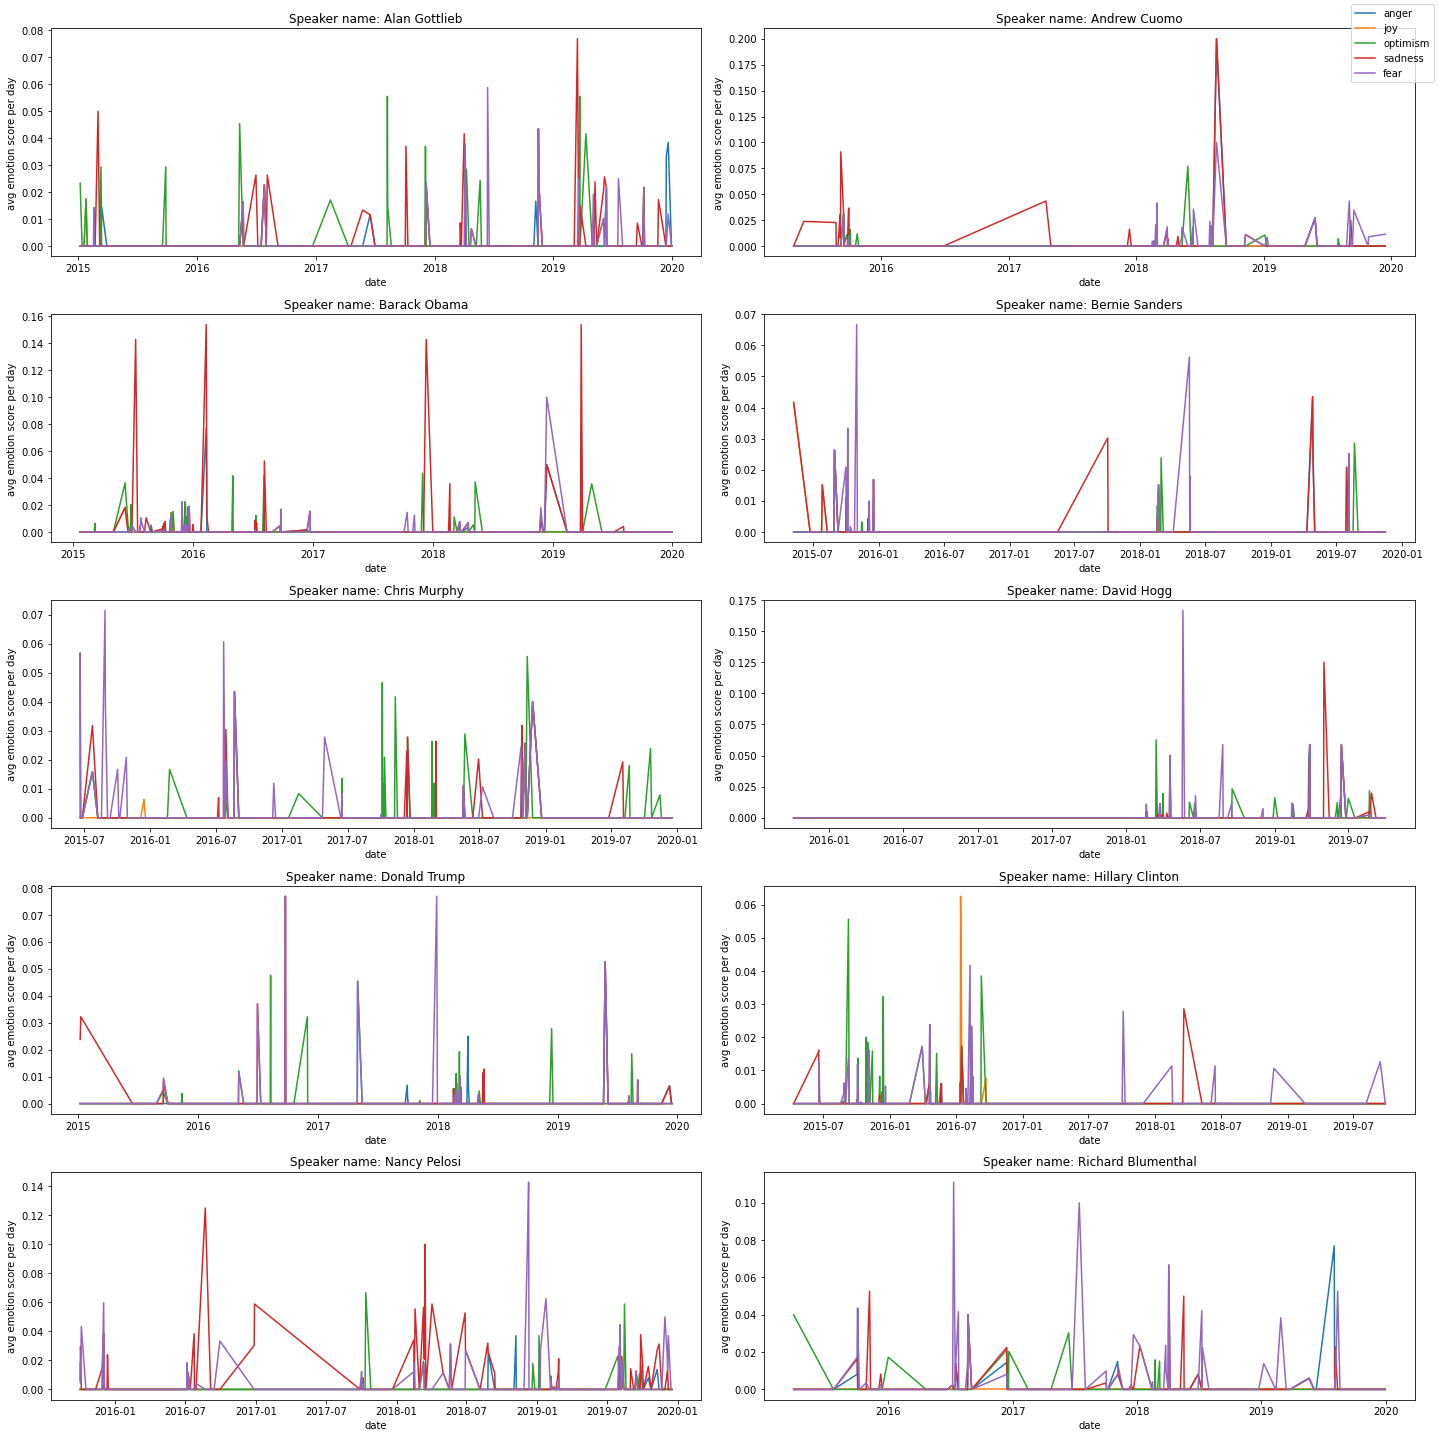

In [18]:
# Set the dates back to date_time in order to graph easily
daily_emotion_df.date=pd.to_datetime(daily_emotion_df.date)

# Graph result
fig, ax = plt.subplots(5, 2);
fig.set_size_inches(20, 20)

idx = 0

# Group scores by event_ID to plot each graph
grouped_df = daily_emotion_df.groupby(['speaker'])
for group in grouped_df:
    row_num = (idx // 2)
    col_num = (idx - 2*row_num)
    idx += 1
    ax[row_num,col_num].plot(group[1].date, group[1].anger,label = "anger");
    #ax[row_num,col_num].plot(group[1].date, group[1].aggression,label = "aggression");
    ax[row_num,col_num].plot(group[1].date, group[1].joy,label = "joy");
    ax[row_num,col_num].plot(group[1].date, group[1].optimism,label = "optimism");
    ax[row_num,col_num].plot(group[1].date, group[1].sadness,label = "sadness");
    #ax[row_num,col_num].plot(group[1].date, group[1].suffering,label = "suffering");
    ax[row_num,col_num].plot(group[1].date, group[1].fear,label = "fear");
    #ax[row_num,col_num].plot(group[1].date, group[1].disappointment,label = "disappointment");
    
    ax[row_num,col_num].set_xlabel("date");
    ax[row_num,col_num].set_ylabel("avg emotion score per day");
    ax[row_num,col_num].set_title('Speaker name: '+str(group[0]));


handles, labels = ax[row_num,col_num].get_legend_handles_labels();
fig.legend(handles, labels, loc='upper right');
fig.tight_layout()